# Breast Cancer prediction

### Dataset features obtained based on digitalized images of fine needle aspirate (FNA) of a breast mass.
### Target variable: Diagnosis based on malignant ou benign node

Dataset from uci archive
http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pickle
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score

2023-07-07 10:40:20.220070: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 10:40:20.738182: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Loading data in csv format
dataset = pd.read_csv('Data/dataset.csv');print('Shape: ',dataset.shape);dataset.head()

Shape:  (569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,points_worst,symmetry_worst,dimension_worst
0,87139402,B,12.32,12.39,78.85,464.1,0.10280,0.06981,0.03987,0.03700,...,13.50,15.64,86.97,549.1,0.1385,0.1266,0.12420,0.09391,0.2827,0.06771
1,8910251,B,10.60,18.95,69.28,346.4,0.09688,0.11470,0.06387,0.02642,...,11.88,22.94,78.28,424.8,0.1213,0.2515,0.19160,0.07926,0.2940,0.07587
2,905520,B,11.04,16.83,70.92,373.2,0.10770,0.07804,0.03046,0.02480,...,12.41,26.44,79.93,471.4,0.1369,0.1482,0.10670,0.07431,0.2998,0.07881
3,868871,B,11.28,13.39,73.00,384.8,0.11640,0.11360,0.04635,0.04796,...,11.92,15.77,76.53,434.0,0.1367,0.1822,0.08669,0.08611,0.2102,0.06784
4,9012568,B,15.19,13.21,97.65,711.8,0.07963,0.06934,0.03393,0.02657,...,16.20,15.73,104.50,819.1,0.1126,0.1737,0.13620,0.08178,0.2487,0.06766


In [3]:
# Drop id field, unuseless for the analysis
dataset.drop('id', axis = 1, inplace=True)

In [4]:
# Verifing missing values
dataset.isna().sum()

diagnosis            0
radius_mean          0
texture_mean         0
perimeter_mean       0
area_mean            0
smoothness_mean      0
compactness_mean     0
concavity_mean       0
points_mean          0
symmetry_mean        0
dimension_mean       0
radius_se            0
texture_se           0
perimeter_se         0
area_se              0
smoothness_se        0
compactness_se       0
concavity_se         0
points_se            0
symmetry_se          0
dimension_se         0
radius_worst         0
texture_worst        0
perimeter_worst      0
area_worst           0
smoothness_worst     0
compactness_worst    0
concavity_worst      0
points_worst         0
symmetry_worst       0
dimension_worst      0
dtype: int64

In [5]:
# Some statistical measures from numeric variables
dataset.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,points_mean,symmetry_mean,dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,points_worst,symmetry_worst,dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [6]:
# Main dataset infos
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   diagnosis          569 non-null    object 
 1   radius_mean        569 non-null    float64
 2   texture_mean       569 non-null    float64
 3   perimeter_mean     569 non-null    float64
 4   area_mean          569 non-null    float64
 5   smoothness_mean    569 non-null    float64
 6   compactness_mean   569 non-null    float64
 7   concavity_mean     569 non-null    float64
 8   points_mean        569 non-null    float64
 9   symmetry_mean      569 non-null    float64
 10  dimension_mean     569 non-null    float64
 11  radius_se          569 non-null    float64
 12  texture_se         569 non-null    float64
 13  perimeter_se       569 non-null    float64
 14  area_se            569 non-null    float64
 15  smoothness_se      569 non-null    float64
 16  compactness_se     569 non

In [7]:
# Label encoding of target variabale
dataset.diagnosis = [0 if x == 'B' else 1 for x in dataset.diagnosis]

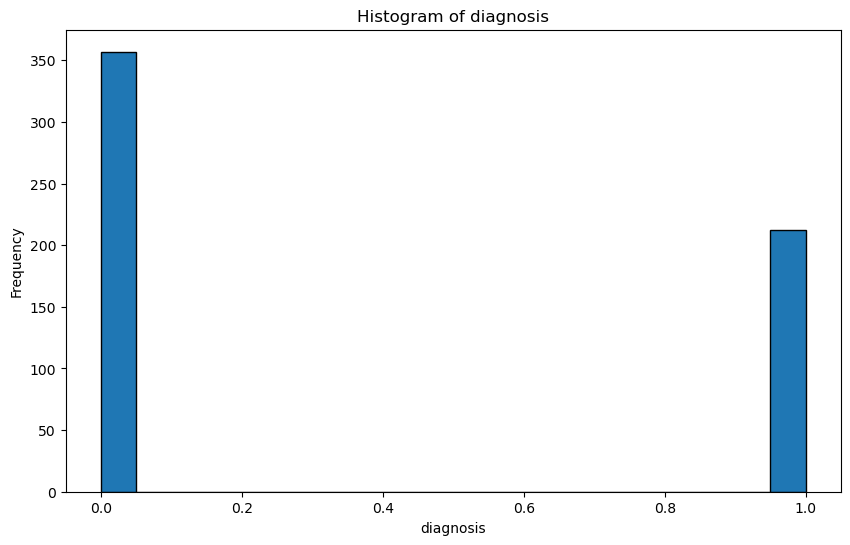

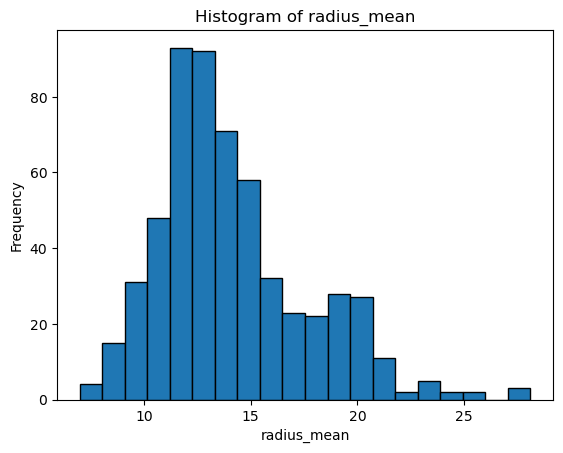

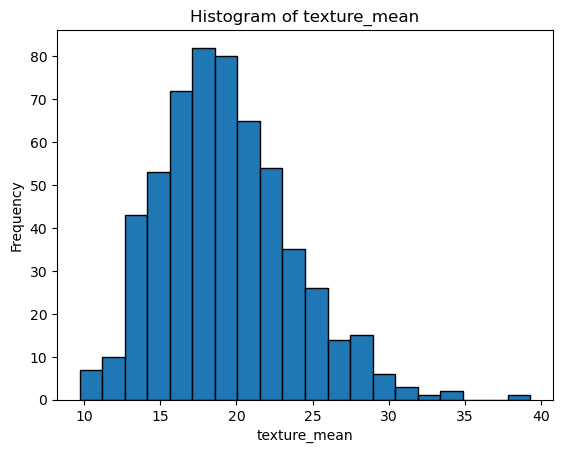

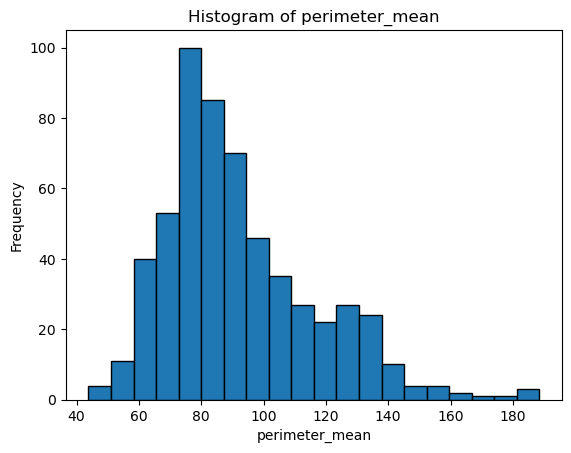

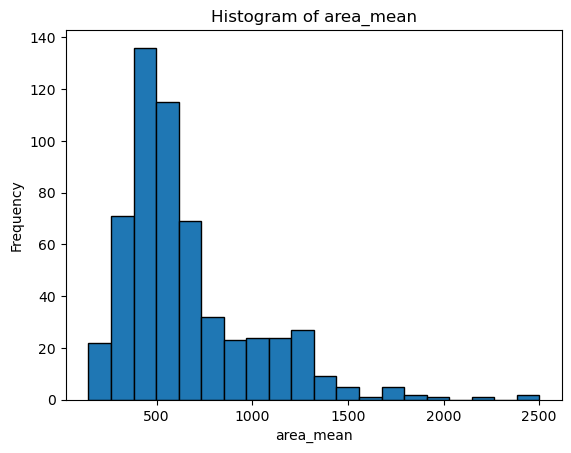

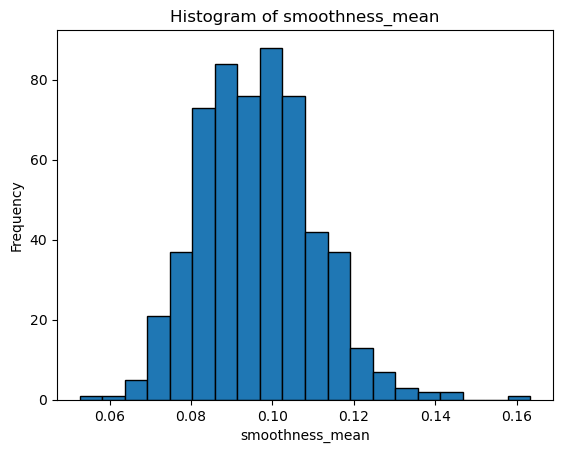

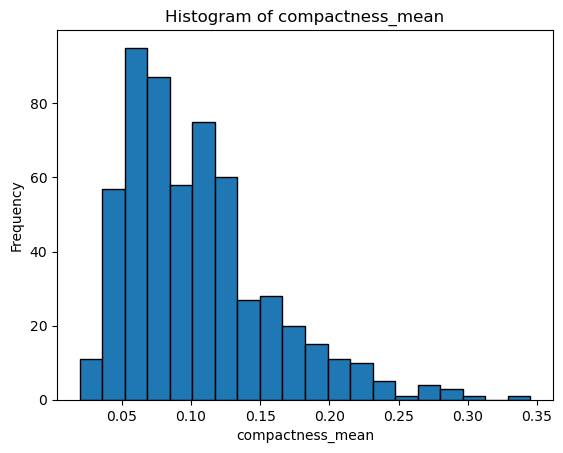

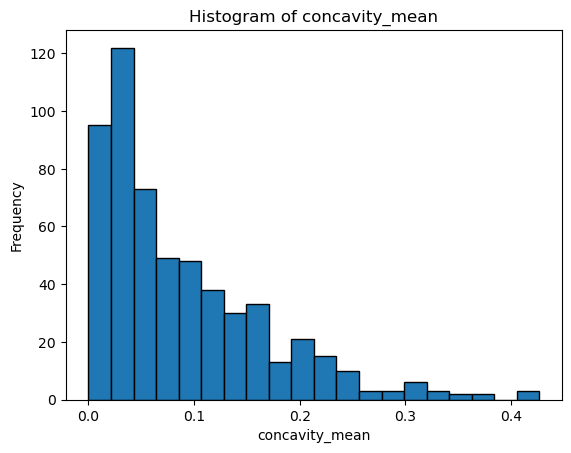

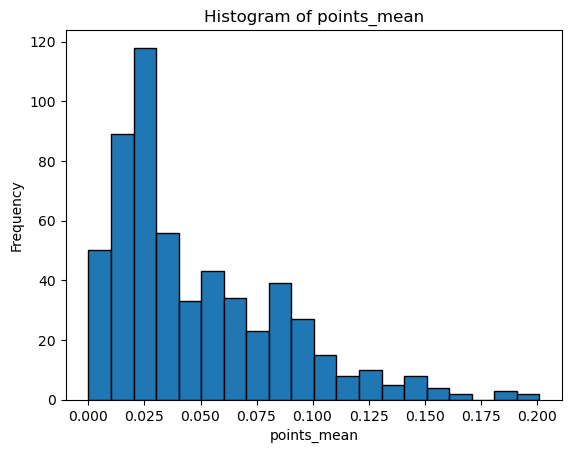

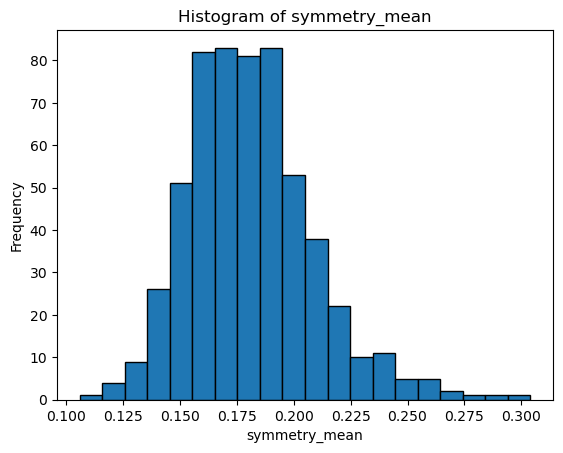

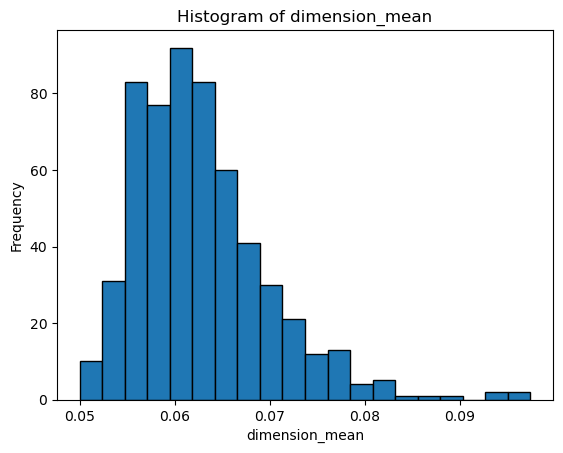

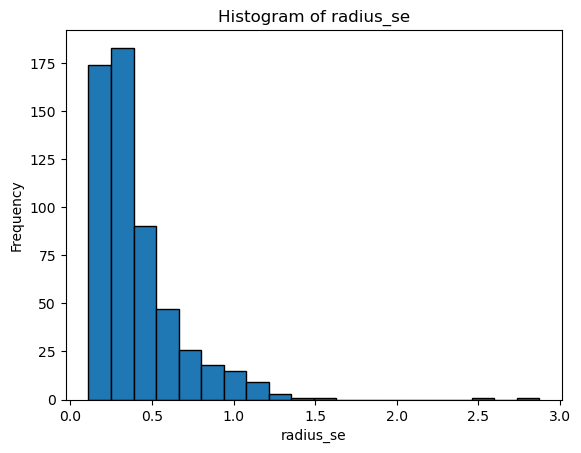

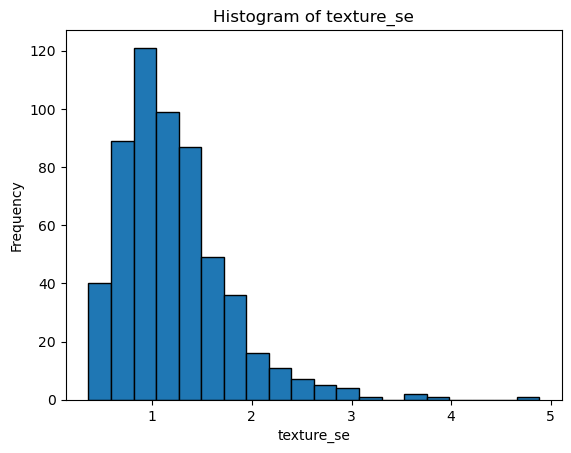

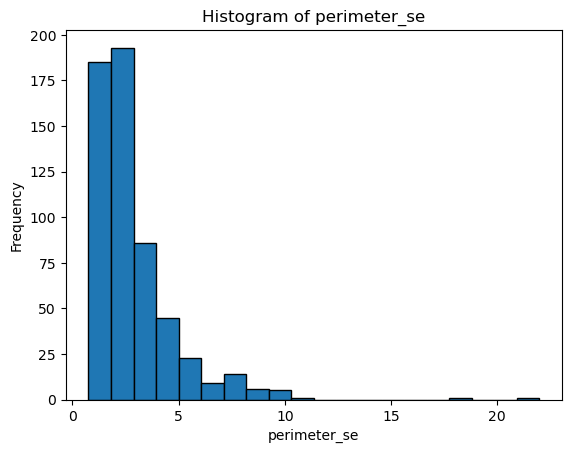

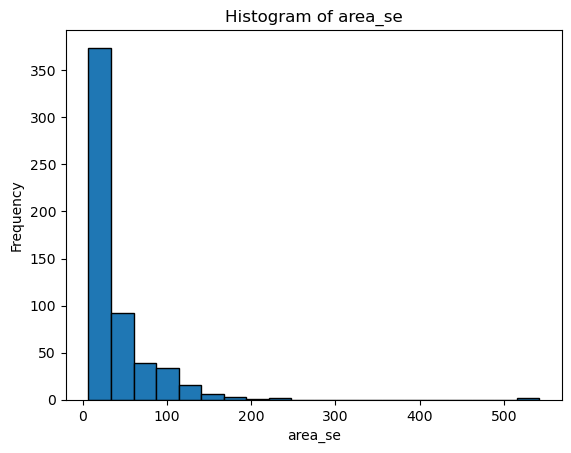

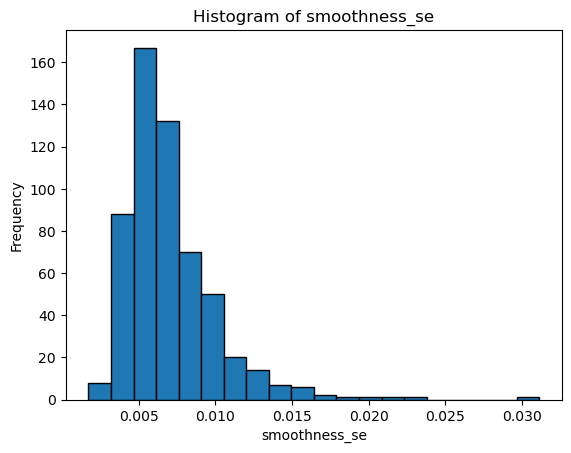

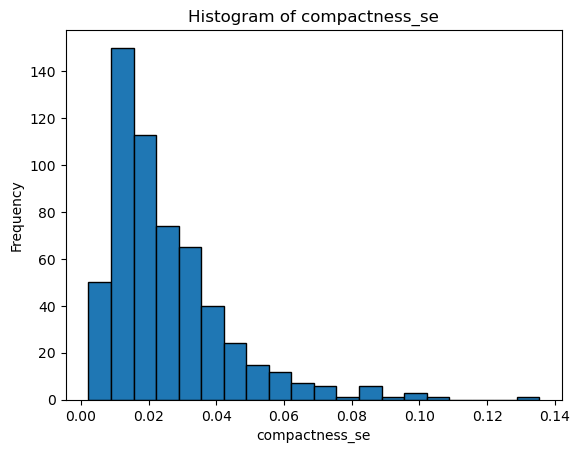

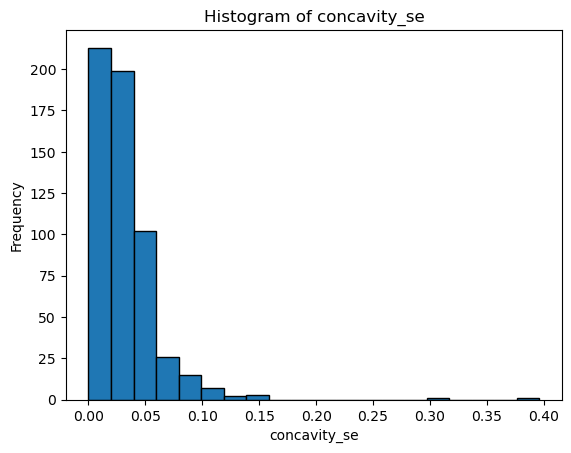

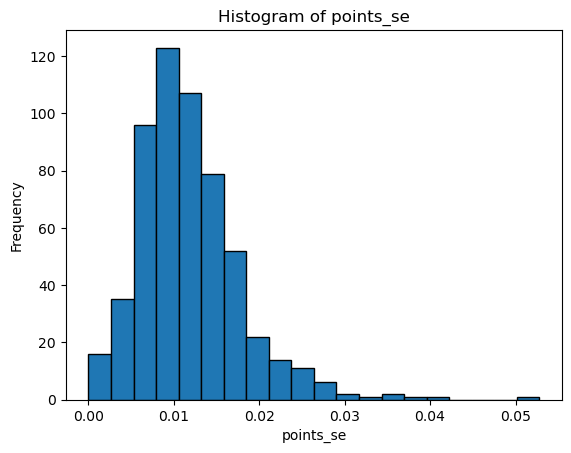

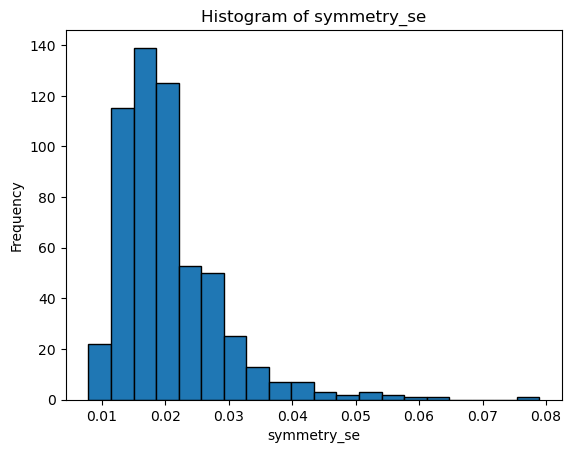

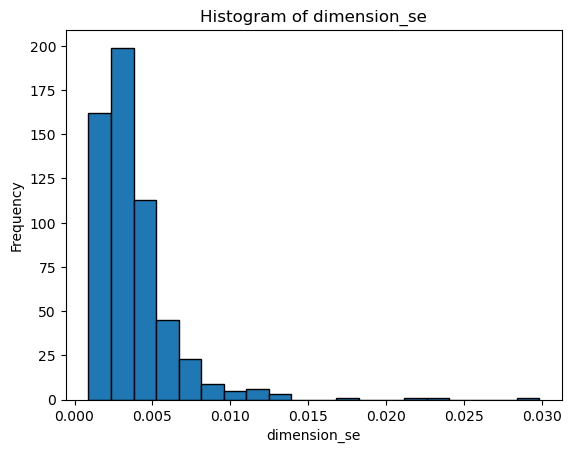

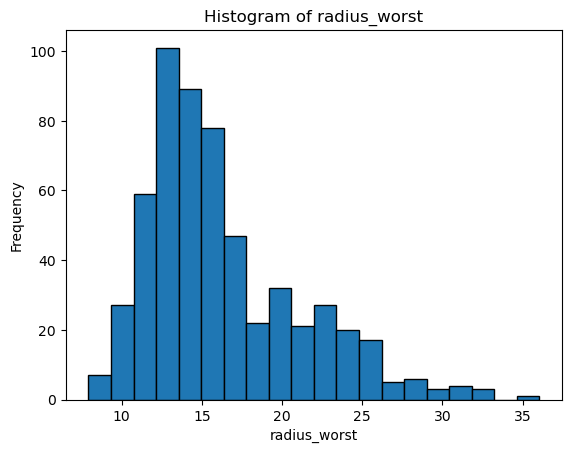

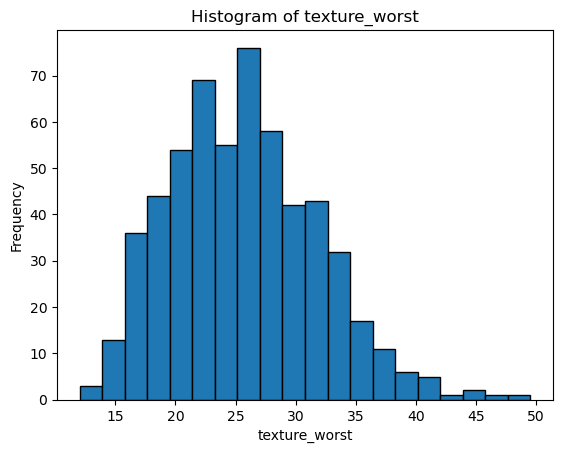

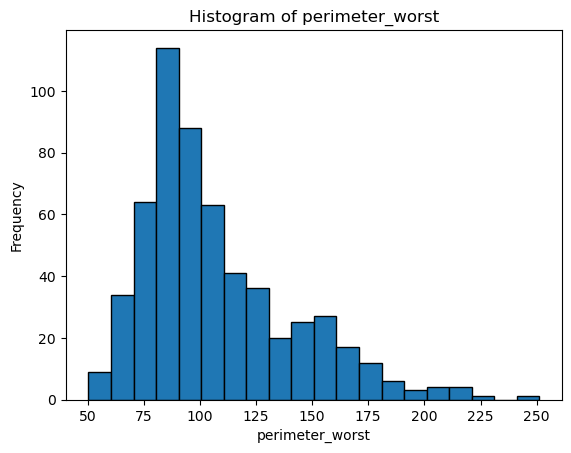

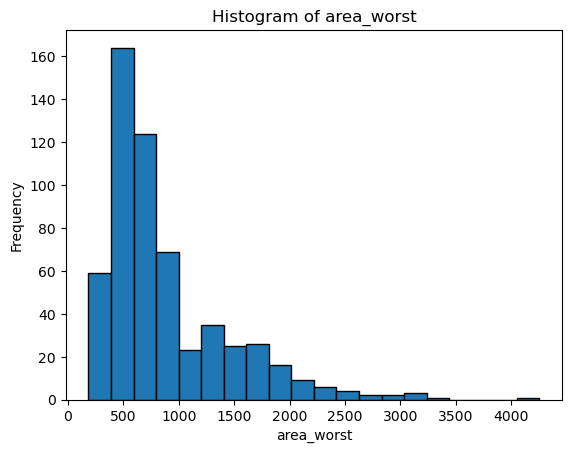

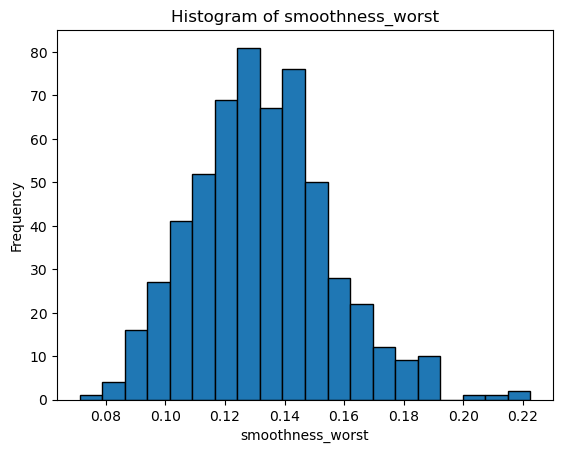

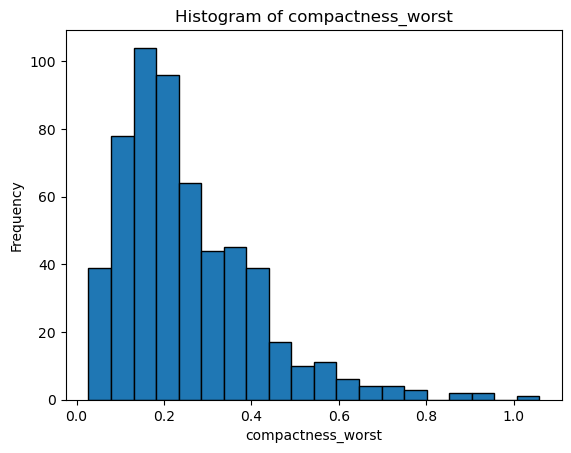

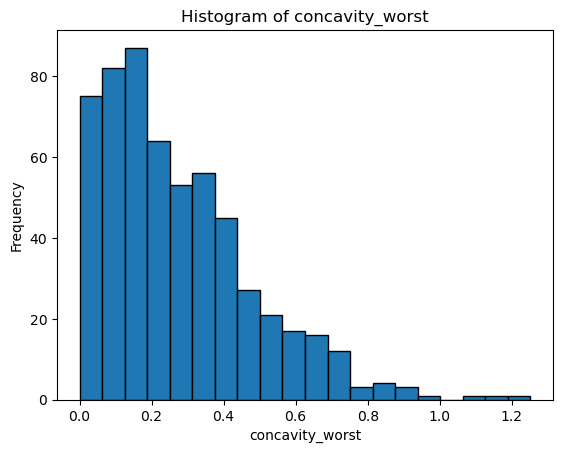

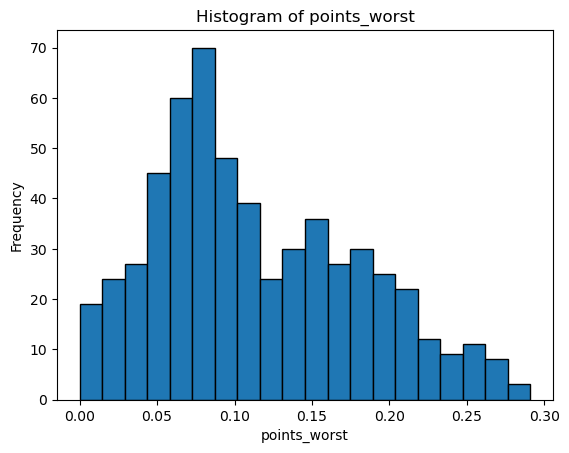

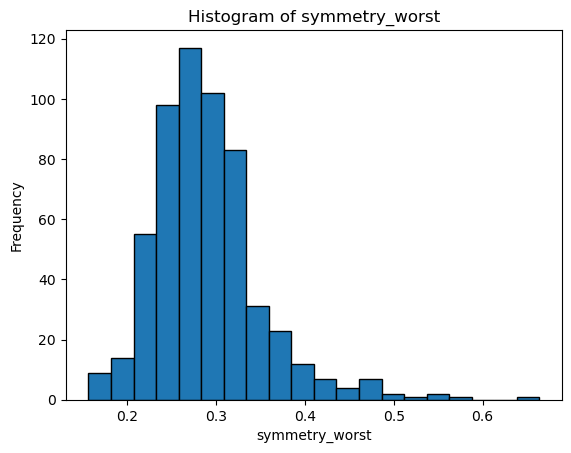

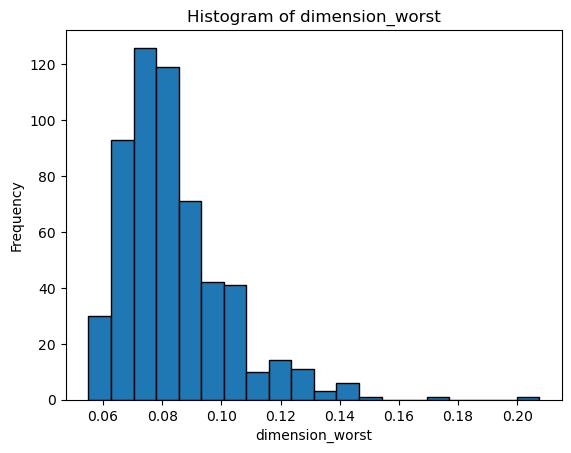

In [8]:
# Histogram plot of numerical variables. Check normal distribution or data anomalies.
plt.figure(figsize=(10, 6))
for column in dataset.columns:
    plt.hist(dataset[column], bins=20, edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.show()

In [9]:
# Dataset split before scale
colNames = dataset.columns.tolist()
predictors = colNames[1:]
target = colNames[0]
X = dataset[predictors]
y = dataset[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(455, 30) (114, 30) (455,) (114,)


In [10]:
# Train and test data standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Array format of train test standardized
X_train_scaled

array([[-0.39809606, -1.4374252 , -0.46398056, ..., -1.14594646,
        -1.82209264, -0.61104325],
       [ 0.61747828,  0.93541144,  0.68815321, ...,  1.63879935,
         3.1213534 ,  0.69607126],
       [ 0.68919964,  2.04644639,  0.65904842, ...,  0.3887512 ,
        -1.11495715, -0.3256993 ],
       ...,
       [ 1.2228065 , -0.17098453,  1.19125024, ...,  0.7261136 ,
         1.28605232,  0.10658824],
       [-1.85576083,  1.44569889, -1.84895262, ..., -1.74687322,
         0.25054587,  0.88060507],
       [ 1.32608524,  0.62923897,  1.29935373, ...,  0.82551502,
         0.16764033, -0.04434219]])

### Since data seems to be normal (or close to it) distributed and no anomalie were found, some pre-selected machine learning models will be trained in order to detect breast cancer

In [12]:
# Grid Search Optimization, training and evaluation of first model using logistic regression (Benchmark model)
tuned_params_v1 = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
                   'penalty': ['l2', 'none']}
model_v1 = GridSearchCV(LogisticRegression(), 
                         tuned_params_v1, 
                         scoring = 'roc_auc', 
                         n_jobs = -1)
model_v1.fit(X_train_scaled, y_train)
# Best model selection
print('Best estimator: ', model_v1.best_estimator_)
y_pred_v1 = model_v1.predict(X_test_scaled)
# Prob based prediction
y_pred_proba_v1 = model_v1.predict_proba(X_test_scaled)
# Filtering predictions by positive class, needed for ROC curve
y_pred_proba_v1 = model_v1.predict_proba(X_test_scaled)[:,1]
# MConfusion Matrix
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred_v1))
# Area Under The Curve
roc_auc_v1 = roc_auc_score(y_test, y_pred_v1)
print('Area Under the curve, roc_auc_score: ', roc_auc_v1)
# ROC curve
fpr_v1, tpr_v1, thresholds = roc_curve(y_test, y_pred_proba_v1)
# AUC
auc_v1 = auc(fpr_v1, tpr_v1)
print('AUC: ', auc_v1)
# Test data accuracy
accuracy_v1 = accuracy_score(y_test, y_pred_v1)
print('Accuracy: ', accuracy_v1)

/home/fernandosantos/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/fernandosantos/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/fernandosantos/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/fernandosantos/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/fernandosantos/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarnin

Best estimator:  LogisticRegression(C=0.1)
Confusion Matrix: 
 [[76  1]
 [ 4 33]]
Area Under the curve, roc_auc_score:  0.9394524394524394
AUC:  0.9950859950859952
Accuracy:  0.956140350877193


/home/fernandosantos/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/fernandosantos/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

In [13]:
# Feature importance
model_v1 = LogisticRegression(C = 1)
model_v1.fit(X_train_scaled, y_train)
index = np.argsort(-abs(model_v1.coef_[0,:]))
print("Most important features for model_v1 results:")
print(50*'-')
for feature in X.columns[index]:
    print(feature)
    # Salve model in disk
with open('MLModels/model_v1.pkl', 'wb') as pickle_file:
      joblib.dump(model_v1, 'MLModels/model_v1.pkl') 
        # Pandas dataframe for models metrics and future comparison
df_models = pd.DataFrame()
dict_model_v1 = {'Name': 'model_v1', 
                  'Algorithm': 'Logistic Regression', 
                  'ROC_AUC Score': roc_auc_v1,
                  'AUC Score': auc_v1,
                  'Accuracy': accuracy_v1}
# Add dict to dataframe
df_models = df_models.append(dict_model_v1, ignore_index = True)
display(df_models)

Most important features for model_v1 results:
--------------------------------------------------
texture_worst
radius_se
concavity_worst
radius_worst
points_mean
area_se
area_worst
dimension_se
concavity_mean
perimeter_worst
symmetry_worst
compactness_se
perimeter_se
smoothness_worst
points_worst
dimension_worst
texture_mean
compactness_mean
area_mean
radius_mean
perimeter_mean
symmetry_se
smoothness_mean
symmetry_mean
concavity_se
points_se
dimension_mean
smoothness_se
texture_se
compactness_worst


/tmp/ipykernel_20805/2544724648.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(dict_model_v1, ignore_index = True)


,Name,Algorithm,ROC_AUC Score,AUC Score,Accuracy
0,model_v1,Logistic Regression,0.939452,0.995086,0.95614


In [14]:
# Grid Search Optimization, training and evaluation of second model using lRandom Forest Classifier
tuned_params_v2 = {'n_estimators': [50, 100, 200, 300, 400, 500],
                   'criterion': ['gini', 'entropy', 'log_loss'],
                   'min_samples_split': [2, 5, 10], 
                   'min_samples_leaf': [1, 2, 4]}
model_v2 = GridSearchCV(RandomForestClassifier(), 
                               tuned_params_v2, 
                               scoring = 'roc_auc', 
                               n_jobs  = -1)
model_v2.fit(X_train_scaled, y_train)
# Best model
print('Best Estimator: ', model_v2.best_estimator_)
# Test data prediction
y_pred_v2 = model_v2.predict(X_test_scaled)
# Filtering predictions by positive class, needed for ROC curve
y_pred_proba_v2 = model_v2.predict_proba(X_test_scaled)[:,1]
# MConfusion Matrix
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred_v2))
# ROC AUC curve
roc_auc_v2 = roc_auc_score(y_test, y_pred_v2)
print("ROC_AUC: ", roc_auc_v2)
# ROC curve
fpr_v2, tpr_v2, thresholds = roc_curve(y_test, y_pred_proba_v2)
# AUC
auc_v2 = auc(fpr_v2, tpr_v2)
print('AUC: ', auc_v2)
# Accuracy
accuracy_v2 = accuracy_score(y_test, y_pred_v2)
print("Accuracy: ", accuracy_v2)

Best Estimator:  RandomForestClassifier(criterion='log_loss', n_estimators=200)
Confusion Matrix:  [[77  0]
 [ 4 33]]
ROC_AUC:  0.9459459459459459
AUC:  0.992979992979993
Accuracy:  0.9649122807017544


In [15]:
# Feature importance extraction
model_v2 = RandomForestClassifier(criterion='entropy', n_estimators = 50, min_samples_split = 5, min_samples_leaf = 2)
model_v2.fit(X_train_scaled, y_train)
# More relevant features
index = np.argsort(-model_v2.feature_importances_)
print("Most important features for model_v2 results:")
print(50*'-')
for feature in X.columns[index]:
    print(feature)
# Salve model in disk
with open('MLModels/model_v2.pkl', 'wb') as pickle_file:
      joblib.dump(model_v2, 'MLModels/model_v2.pkl') 
dict_model_v2 = {'Name': 'model_v2', 
                  'Algorithm': 'Random Forest', 
                  'ROC_AUC Score': roc_auc_v2,
                  'AUC Score': auc_v2,
                  'Accuracy': accuracy_v2}
# Add dict to dataframe
df_models = df_models.append(dict_model_v2, ignore_index = True)
display(df_models)

Most important features for model_v2 results:
--------------------------------------------------
radius_worst
area_worst
perimeter_worst
points_mean
concavity_worst
area_mean
points_worst
concavity_mean
perimeter_mean
area_se
radius_mean
texture_worst
perimeter_se
smoothness_worst
texture_mean
compactness_worst
radius_se
symmetry_worst
compactness_mean
dimension_worst
concavity_se
smoothness_mean
symmetry_se
points_se
texture_se
dimension_se
dimension_mean
smoothness_se
compactness_se
symmetry_mean


/tmp/ipykernel_20805/3868663866.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(dict_model_v2, ignore_index = True)


,Name,Algorithm,ROC_AUC Score,AUC Score,Accuracy
0,model_v1,Logistic Regression,0.939452,0.995086,0.956140
1,model_v2,Random Forest,0.945946,0.992980,0.964912


In [16]:
# Grid Search Optimization, training and evaluation of thrid model using KNN
# K range
neighbors = list(range(1, 20, 2))
# Scores list
cv_scores = []
# Cross validation to determine better k value
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())   
# error adjusting
error = [1 - x for x in cv_scores]
optimal_k = neighbors[error.index(min(error))]
print('k best value is %d' % optimal_k)
# model_v3
model_v3 = KNeighborsClassifier(n_neighbors = optimal_k)
# Training
model_v3.fit(X_train_scaled, y_train)
# Predict
y_pred_v3 = model_v3.predict(X_test_scaled)
# Confusion Matrix
confusion_matrix(y_test, y_pred_v3)
# Prob prediction of positive class
y_pred_proba_v3 = model_v3.predict_proba(X_test_scaled)[:,1]
# ROC_AUC in test data
roc_auc_v3 = roc_auc_score(y_test, y_pred_v3)
print('ROC_AUC: ', roc_auc_v3)
# ROC curve
fpr_v3, tpr_v3, thresholds = roc_curve(y_test, y_pred_proba_v3)
# AUC
auc_v3 = auc(fpr_v3, tpr_v3)
print("AUC", auc_v3)
# CAccuracy
accuracy_v3 = accuracy_score(y_test, y_pred_v3)
print('Accuracy: ', accuracy_v3)
# Save model
with open('MLModels/model_v3.pkl', 'wb') as pickle_file:
      joblib.dump(model_v3, 'MLModels/model_v3.pkl') 
# Dicionário com as métricas do modelo_v3
dict_modelo_v3 = {'Name': 'model_v3', 
                  'Algorithm': 'KNN', 
                  'ROC_AUC Score': roc_auc_v3,
                  'AUC Score': auc_v3,
                  'Accuracy': accuracy_v3}
df_models = df_models.append(dict_modelo_v3, ignore_index = True)
display(df_models)

k best value is 5
ROC_AUC:  0.9259389259389259
AUC 0.9889434889434889
Accuracy:  0.9473684210526315


/tmp/ipykernel_20805/1517595618.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(dict_modelo_v3, ignore_index = True)


,Name,Algorithm,ROC_AUC Score,AUC Score,Accuracy
0,model_v1,Logistic Regression,0.939452,0.995086,0.956140
1,model_v2,Random Forest,0.945946,0.992980,0.964912
2,model_v3,KNN,0.925939,0.988943,0.947368


In [17]:
# Grid Search Optimization, training and evaluation of fourth SVM model
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    kernels = ['linear', 'rbf', 'polynomial']
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel' : kernels}
    grid_search = GridSearchCV(SVC(), param_grid, cv = nfolds)
    grid_search.fit(X_train_scaled, y_train)
    grid_search.best_params_
    return grid_search.best_params_
print('Best params: ', svc_param_selection(X_train_scaled, y_train, 10))

Best params:  {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


/home/fernandosantos/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fernandosantos/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fernandosantos/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py", line 180, in fit
    self._validate_params()
  File "/home/fernandosantos/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 581, in _validate_params
    validate_paramete

In [18]:
# Setting best model
model_v4 = SVC(C = 0.1, gamma = 0.001, kernel = 'linear', probability = True)
# Training
model_v4.fit(X_train_scaled, y_train)
# Predicting
y_pred_v4 = model_v4.predict(X_test_scaled)
confusion_matrix(y_test, y_pred_v4)
# Prob format
y_pred_proba_v4 = model_v4.predict_proba(X_test_scaled)[:, 1]
# ROC AUC score
roc_auc_v4 = roc_auc_score(y_test, y_pred_v4)
print('ROC_AUC: ', roc_auc_v4)
# ROC curve
fpr_v4, tpr_v4, thresholds = roc_curve(y_test, y_pred_proba_v4)
# UC score
auc_v4 = auc(fpr_v4, tpr_v4)
print('AUC: ', auc_v4)
# Accuracy
accuracy_v4 = accuracy_score(y_test, y_pred_v4)
print(accuracy_v4)
# Saving model
with open('MLModels/model_v4.pkl', 'wb') as pickle_file:
      joblib.dump(model_v4, 'MLModels/model_v4.pkl') 
# Model_v4 dict
dict_model_v4 = {'Name': 'model_v4', 
                  'Algorithm': 'SVM', 
                  'ROC_AUC Score': roc_auc_v4,
                  'AUC Score': auc_v4,
                  'Accuracy': accuracy_v4}
# add to dataframe
df_models = df_models.append(dict_model_v4, ignore_index = True)
display(df_models)

ROC_AUC:  0.9464724464724464
AUC:  0.9943839943839943
0.956140350877193


/tmp/ipykernel_20805/727012021.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(dict_model_v4, ignore_index = True)


,Name,Algorithm,ROC_AUC Score,AUC Score,Accuracy
0,model_v1,Logistic Regression,0.939452,0.995086,0.956140
1,model_v2,Random Forest,0.945946,0.992980,0.964912
2,model_v3,KNN,0.925939,0.988943,0.947368
3,model_v4,SVM,0.946472,0.994384,0.956140


In [19]:
# Modeling, training and evaluation of LSTM model
X_train = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

model_v5 = Sequential()
model_v5.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model_v5.add(Dense(units=32, activation='relu'))
model_v5.add(Dense(units=1, activation='sigmoid'))

model_v5.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

model_v5.fit(X_train, y_train, batch_size=32, epochs=100)

loss, accuracy = model_v5.evaluate(X_test, y_test)

2023-07-07 10:41:07.514048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-07 10:41:07.530802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-07 10:41:07.530978: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/100


2023-07-07 10:41:08.297644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-07 10:41:08.298505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-07 10:41:08.299316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 2s 3ms/step - loss: 0.5882 - accuracy: 0.8637
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.3364 - accuracy: 0.9055
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.2569 - accuracy: 0.9253
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.2257 - accuracy: 0.9341
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.2254 - accuracy: 0.9297
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.2165 - accuracy: 0.9319
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.2113 - accuracy: 0.9363
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.1968 - accuracy: 0.9385
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.2014 - accuracy: 0.9297
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1858 - accuracy: 0.9341
Epoch 11/100
15/15 [=

15/15 [==============================] - 0s 3ms/step - loss: 0.0963 - accuracy: 0.9692
Epoch 84/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1000 - accuracy: 0.9604
Epoch 85/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1060 - accuracy: 0.9648
Epoch 86/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0803 - accuracy: 0.9736
Epoch 87/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0728 - accuracy: 0.9714
Epoch 88/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0871 - accuracy: 0.9692
Epoch 89/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0861 - accuracy: 0.9648
Epoch 90/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0804 - accuracy: 0.9736
Epoch 91/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0762 - accuracy: 0.9758
Epoch 92/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0697 - accuracy: 0.9714
Epoch 93/100


2023-07-07 10:41:15.433360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-07 10:41:15.434101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-07 10:41:15.434994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [20]:
y_pred = model_v5.predict(X_test_scaled)
# Calculate ROC AUC score
roc_auc_v5 = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc_v5)
# Calculate AUC score
auc_v5 = roc_auc_score(y_test, y_pred, max_fpr=1.0)
print("AUC Score:", auc_v5)
loss, accuracy_v5 = model_v5.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy_v5:.4f}')
# Save the model
with open('MLModels/model_v5.pkl', 'wb') as pickle_file:
      joblib.dump(model_v5, 'MLModels/model_v5.pkl') 
# model_v6 metrics
dict_model_v5 = {'Name': 'model_v5', 
                  'Algorithm': 'LSTM', 
                  'ROC_AUC Score': roc_auc_v5,
                  'AUC Score': auc_v5,
                  'Accuracy': accuracy_v5}
# Add to dataframe
df_models = df_models.append(dict_model_v5, ignore_index = True)
display(df_models)

4/4 [==============================] - 0s 1ms/step
ROC AUC Score: 0.9764829764829764
AUC Score: 0.9764829764829764
4/4 [==============================] - 0s 2ms/step - loss: 0.1945 - accuracy: 0.9211
Test Loss: 0.1945
Test Accuracy: 0.9211


2023-07-07 10:41:15.686327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-07 10:41:15.687314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-07 10:41:15.688001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

,Name,Algorithm,ROC_AUC Score,AUC Score,Accuracy
0,model_v1,Logistic Regression,0.939452,0.995086,0.956140
1,model_v2,Random Forest,0.945946,0.992980,0.964912
2,model_v3,KNN,0.925939,0.988943,0.947368
3,model_v4,SVM,0.946472,0.994384,0.956140
4,modelo_v5,LSTM,0.976483,0.976483,0.921053


In [21]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001, 0.0001],
    'n_estimators': [100, 200, 300],
    'gamma': [0.0001,0.001, 0.1, 0.5, 1, 10, 100],
}
# Create the XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Perform grid search cross-validation
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
model_v6 = grid_search.best_estimator_

y_pred = model_v6.predict(X_test_scaled)

# Evaluate the model
accuracy_v6 = accuracy_score(y_test, y_pred)
roc_auc_v6 = roc_auc_score(y_test, y_pred)
auc_v6 = roc_auc_score(y_test, y_pred, max_fpr=1.0)

# Save model
with open('MLModels/model_v6.pkl', 'wb') as pickle_file:
      joblib.dump(model_v6, 'MLModels/model_v6.pkl') 

# Metrics
dict_model_v6 = {'Name': 'model_v6', 
                  'Algorithm': 'XGBoost', 
                  'ROC_AUC Score': roc_auc_v6,
                  'AUC Score': auc_v6,
                  'Accuracy': accuracy_v6}

print(f'Accuracy: {accuracy_v6:.4f}')
print(f'ROC AUC: {roc_auc_v6:.4f}')

print("Best Hyperparameters:", best_params)

# Add dict to dataframe
df_models = df_models.append(dict_model_v6, ignore_index = True)
display(df_models)

Accuracy: 0.9737
ROC AUC: 0.9595
Best Hyperparameters: {'gamma': 0.0001, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


/tmp/ipykernel_20805/2029317057.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(dict_model_v6, ignore_index = True)


,Name,Algorithm,ROC_AUC Score,AUC Score,Accuracy
0,model_v1,Logistic Regression,0.939452,0.995086,0.956140
1,model_v2,Random Forest,0.945946,0.992980,0.964912
2,model_v3,KNN,0.925939,0.988943,0.947368
3,model_v4,SVM,0.946472,0.994384,0.956140
4,modelo_v5,LSTM,0.976483,0.976483,0.921053
5,model_v6,XGBoost,0.959459,0.959459,0.973684


In [22]:
### Best model selection
# Since AUC Score is o global metric, it will be used to select best model for this solution.
df_best_model = df_models[df_models['AUC Score'] == df_models['AUC Score'].max()]
print(df_best_model)

       Name            Algorithm  ROC_AUC Score  AUC Score  Accuracy
0  model_v1  Logistic Regression       0.939452   0.995086   0.95614


In [32]:
## Prediction with best model
# Name
model = df_best_model.Name.to_string(index = False)
# Loading from disk
best_model = joblib.load('MLModels/' + model + '.pkl')
# Raw data of new pacient
new_pacient = [10.6,18.95,69.28,346.4,0.09688,0.1147,0.06387,0.02642,0.1922,0.06491,0.4505,1197,3.43,27.1,0.00747,0.03581,0.03354,0.01365,0.03504,0.003318,11.88,22.94,78.28,424.8,0.1213,0.2515,0.1916,0.07926,294,0.07587]
print(len(new_pacient))
# Convert to np.array
arr_pacient = np.array(new_pacient).reshape(1,-1)
#Apply scaler
arr_pacient = scaler.transform(arr_pacient)
# Convert to np.array
arr_pacient = np.array(arr_pacient)
# Class prediction
pred_new_pacient = best_model.predict(arr_pacient.reshape(1, -1))
print(pred_new_pacient)
# Verify and print result
if pred_new_pacient == 1:
    print('This pacient should present breast cancer')
else:
    print('This pacient should not present breast cancer')

30
[1]
This pacient should present breast cancer


/home/fernandosantos/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
